## Stochastic MPC using State Estimation and Terminal Cost

# Specify perturbation

In [ ]:
import numpy as np

# np.random.seed(42)
nx = 25  # number of grid blocks
Ne = 3 # number of perturbation
amean = 20.0
bmean = 5.0
a_std = 2.0
b_std = 0.5
amin = 18.0
amax = 22.0
bmin = 4.5
bmax = 5.5

# aw.shape

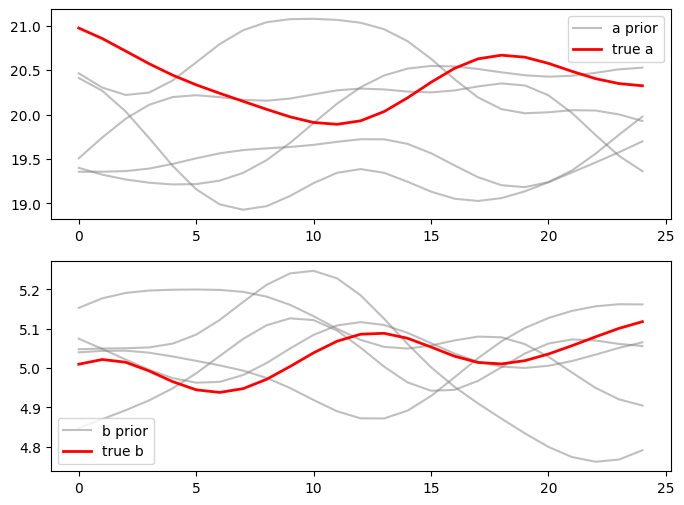

In [ ]:
import gstools as gs
import scipy.stats



if True:
    aw = np.zeros((nx, Ne))
    bw = np.zeros((nx, Ne))
    
    for i in range(Ne):
        model = gs.Gaussian(dim=1, var=0.1, len_scale=5)
        srf = gs.SRF(model)
        x = range(25)
        srf(x, mesh_type='structured')
        fieldcdf = scipy.stats.norm.cdf(srf.field, 0, 1)
        a = (amin - amean) / a_std
        b = (amax - amean) / a_std
        var = scipy.stats.truncnorm.ppf(fieldcdf, a, b)
        _aw = var*a_std + amean

        model = gs.Gaussian(dim=1, var=0.1, len_scale=5)
        srf = gs.SRF(model)
        x = range(25)
        srf(x, mesh_type='structured')
        fieldcdf = scipy.stats.norm.cdf(srf.field, 0, 1)
        a = (bmin - bmean) / b_std
        b = (bmax - bmean) / b_std
        var = scipy.stats.truncnorm.ppf(fieldcdf, a, b)
        _bw = var*b_std + bmean

        aw[:,i] = _aw
        bw[:,i] = _bw

    np.save("./data/aw.npy", aw)
    np.save("./data/bw.npy", bw)
    
if False:
    model = gs.Gaussian(dim=1, var=0.1, len_scale=5)
    srf = gs.SRF(model)
    x = range(25)
    srf(x, mesh_type='structured', seed=42)
    fieldcdf = scipy.stats.norm.cdf(srf.field, 0, 1)
    a = (amin - amean) / a_std
    b = (amax - amean) / a_std
    var = scipy.stats.truncnorm.ppf(fieldcdf, a, b)
    _aw = var*a_std + amean

    model = gs.Gaussian(dim=1, var=0.1, len_scale=5)
    srf = gs.SRF(model)
    x = range(25)
    srf(x, mesh_type='structured', seed=67)
    fieldcdf = scipy.stats.norm.cdf(srf.field, 0, 1)
    a = (bmin - bmean) / b_std
    b = (bmax - bmean) / b_std
    var = scipy.stats.truncnorm.ppf(fieldcdf, a, b)
    _bw = var*b_std + bmean

    a_true = _aw*1
    b_true = _bw*1
    
    np.save("./data/a_true.npy", a_true)
    np.save("./data/b_true.npy", b_true)
    
    
import matplotlib.pyplot as plt

aw = np.load("./data/aw.npy")
bw = np.load("./data/bw.npy")

a_true = np.load("./data/a_true.npy")
b_true = np.load("./data/b_true.npy")

fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(aw, color='gray', alpha=0.5)
ax[0].plot(a_true, color='red', linewidth=2)
ax[1].plot(bw, color='gray', alpha=0.5)
ax[1].plot(b_true, color='red', linewidth=2)
ax[0].plot([], color='gray', alpha=0.5, label="a prior")
ax[0].plot([], color='red', linewidth=2, label="true a")
ax[1].plot([], color='gray', alpha=0.5, label="b prior")
ax[1].plot([], color='red', linewidth=2, label="true b")
ax[0].legend()
ax[1].legend()
plt.show()

## Find the solution to the stochastic OCP solution 

In [3]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort
from solver_socp_te import SolverOcp

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw", nx, Ne)
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym[:,i], bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])


if True:
    qocp = np.load("./data/stochastic_socp_qt.npy")[0]

    n_mpc_steps = 1
    N_mpc = 100

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                aw = aw,
                                bw = bw)

    nx = params_mpc.nx

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()

    qmpc = [1.0]

    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        ocp = setup_sbl_ocp(params_mpc, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        if mpc_step == 0:
            f_discrete = ocp.bl.simulate_at_k
            f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        solver = SolverOcp(ocp, itk=mpc_step)
        solver.set_initial_guess(Sw0, qt)
        x_traj, u_traj = solver.solve(Sw0)

    qocp = np.insert(u_traj[:,0], 0, 1.0)[:-1]
        

    # Compute the cost from the OCP solutions


    Sw_traj = []
    cost_traj = []
    for k, q in enumerate(qocp):
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, q)*(0.99**k)
            # costs.append(cost.full()[0,0])
            costs.append(cost)
            
        Sw_mpc = f(Sw_mpc, q, aw, bw)
        Sw_traj.append(Sw_mpc)
        cost_traj.append(costs)
        

    qocp = np.array(qocp)
    Sw_traj = np.array(Sw_traj)  # (n_mpc_steps, nx*Ne)
    cost_traj = np.array(cost_traj)  # (n_mpc_steps, Ne)

    np.save("./data/socp_qocp.npy", qocp)
    np.save("./data/socp_Sw_traj.npy", Sw_traj)
    np.save("./data/socp_cost_traj.npy", cost_traj)
        

  0%|          | 0/1 [00:00<?, ?it/s]

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), SX(q_10), SX(q_11), SX(q_12), SX(q_13), SX(q_14), SX(q_15), SX(q_16), SX(q_17), SX(q_18), SX(q_19), SX(q_20), SX(q_21), SX(q_22), SX(q_23), SX(q_24), SX(q_25), SX(q_26), SX(q_27), SX(q_28), SX(q_29), SX(q_30), SX(q_31), SX(q_32), SX(q_33), SX(q_34), SX(q_35), SX(q_36), SX(q_37), SX(q_38), SX(q_39), SX(q_40), SX(q_41), SX(q_42), SX(q_43), SX(q_44), SX(q_45), SX(q_46), SX(q_47), SX(q_48), SX(q_49), SX(q_50), SX(q_51), SX(q_52), SX(q_53), SX(q_54), SX(q_55), SX(q_56), SX(q_57), SX(q_58), SX(q_59), SX(q_60), SX(q_61), SX(q_62), SX(q_63), SX(q_64), SX(q_65), SX(q_66), SX(q_67), SX(q_68), SX(q_69), SX(q_70), SX(q_71), SX(q_72), SX(q_73), SX(q_74), SX(q_75), SX(q_76), SX(q_77), SX(q_78), SX(q_79), SX(q_80), SX(q_81), SX(q_82), SX(q_83), SX(q_84), SX(q_85), SX(q_86), SX(q_87), SX(q_88), SX(q_89), SX(q_90), SX(q_91), SX(q_92), SX(q_93), SX(q_94), SX(q_95), S

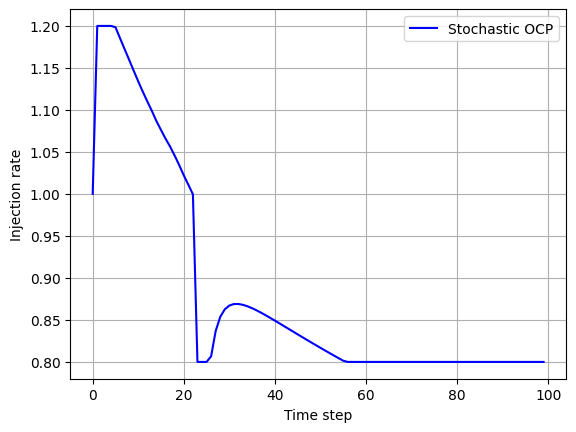

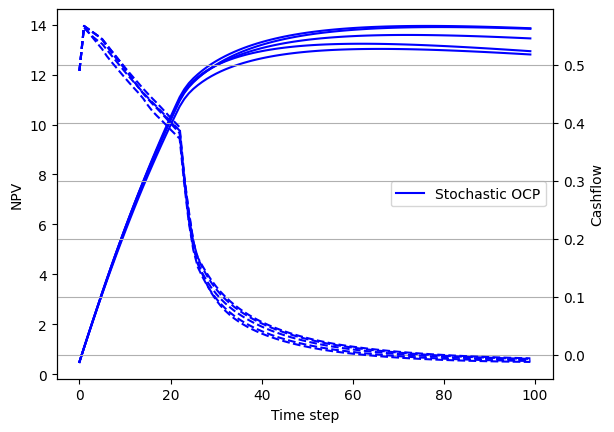

In [4]:

fig, ax = plt.subplots()
qocp = np.load("./data/socp_qocp.npy")
ax.plot(qocp, label="Stochastic OCP", color="blue")
ax.legend()
ax.set_ylabel("Injection rate")
ax.set_xlabel("Time step")
ax.set_ylim([0.78, 1.22])
ax.grid()
plt.show()

ocp_cashflow = np.load("./data/socp_cost_traj.npy")[:,:,0,0]

fig, ax = plt.subplots()
ax.plot(np.cumsum(ocp_cashflow, axis=0), color='blue')
ax.plot([], color='blue', label="Stochastic OCP")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(ocp_cashflow, color="blue", linestyle="dashed")
ax1.set_ylabel("Cashflow")

ax1.grid()


## Compute terminal cost using optimal control solution to the stochastic OCP

In [ ]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort
from solver_socp_te import SolverOcp

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw", nx, Ne)
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym[:,i], bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])

if True:
    qocp = np.load("./data/socp_qocp.npy")

    n_mpc_steps = 100
    N_mpc = 10

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                aw = aw,
                                bw = bw)

    nx = params_mpc.nx

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()

    qmpc = [1.0]
    Sw_traj = []

    cost_traj = []


    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        ocp = setup_sbl_ocp(params_mpc, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        if mpc_step == 0:
            f_discrete = ocp.bl.simulate_at_k
            f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(0.99**mpc_step)
            costs.append(cost)
            
        cost_traj.append(costs)
        
        solver = SolverOcp(ocp, itk=mpc_step)
        solver.set_initial_guess(Sw0, qt)
        x_traj, u_traj = solver.solve(Sw0)
        
        qmpc.append(u_traj[0,0]*1)
        
        Sw_mpc = f(Sw_mpc, u_traj[0,0], aw, bw)
        Sw_traj.append(Sw_mpc)
        
        

    qmpc = np.array(qmpc)
    Sw_traj = np.array(Sw_traj)  # (n_mpc_steps, nx*Ne)
    cost_traj = np.array(cost_traj)  # (n_mpc_steps, Ne)

    np.save("./data/smpc_qmpc.npy", qmpc)
    np.save("./data/smpc_Sw_traj.npy", Sw_traj)
    np.save("./data/smpc_cost_traj.npy", cost_traj)
        

  0%|          | 0/100 [00:00<?, ?it/s]

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), 1.1339590653190605, 1.1216487078050372, 1.109988654422151, 1.098716174174965, 1.0865924777718654, 1.0760888760478133, 1.0657206380090916, 1.0562557500012333, 1.0455820743424868, 1.0341688267268836, 1.022090890820154, 1.0109369832557151, 0.9996090729126653, 0.8000000111365276, 0.8000000242630616, 0.800000094078416, 0.8067111453217775, 0.8368172284897084, 0.8535979229229144, 0.8626122374865677, 0.8671128152042709, 0.8688981162363051, 0.8689820109678932, 0.867960917011165, 0.8662020616262646, 0.8639410678286642, 0.8613344243960565, 0.8584889813048184, 0.8554792942051515, 0.852358262905938, 0.849163906329976, 0.8459238181323837, 0.8426581763967754, 0.8393818212507549, 0.8361057143954712, 0.83283797846343, 0.829584645931909, 0.8263502035431388, 0.8231379914181928, 0.8199504979981009, 0.8167895802186349, 0.8136566310792089, 0.8105527147660307, 0.807478702

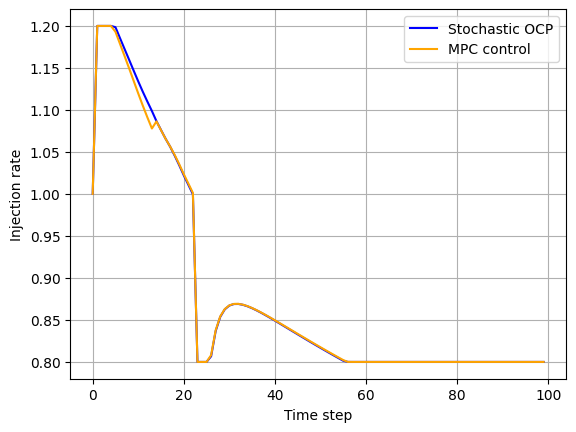

(13.379658299576372, 13.466571841659094)

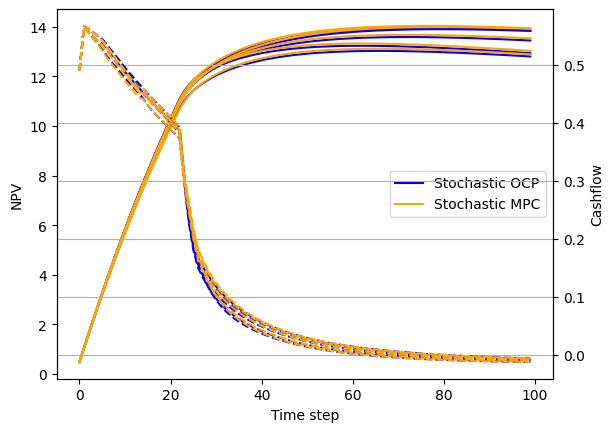

In [6]:
fig, ax = plt.subplots()
qocp = np.load("./data/socp_qocp.npy")
qmpc = np.load("./data/smpc_qmpc.npy")
ax.plot(qocp, label="Stochastic OCP", color="blue")
plt.plot(qmpc[:-1], label="MPC control", color="orange")
ax.legend()
ax.set_ylabel("Injection rate")
ax.set_xlabel("Time step")
ax.set_ylim([0.78, 1.22])
ax.grid()
plt.show()

socp_cost = np.load("./data/socp_cost_traj.npy")[:,:,0,0]
smpc_cost = np.load("./data/smpc_cost_traj.npy")[:,:,0,0]

fig, ax = plt.subplots()
ax.plot(np.cumsum(socp_cost, axis=0), color='blue')
ax.plot(np.cumsum(smpc_cost, axis=0), color='orange')
ax.plot([], color='blue', label="Stochastic OCP")
ax.plot([], color='orange', label="Stochastic MPC")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(socp_cost, color="blue", linestyle="dashed")
ax1.plot(smpc_cost, color="orange", linestyle="dashed")
ax1.set_ylabel("Cashflow")

ax1.grid()


npv_socp = np.cumsum(socp_cost, axis=0)[-1,:].mean()
npv_smpc = np.cumsum(smpc_cost, axis=0)[-1,:].mean()

npv_socp, npv_smpc

## Compute the cost using the optimal control on the true model, then update the parameter

In [ ]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort, BLParamsTrue
from solver_socp_te import SolverOcp

from kalman_filter import ESMDA

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw", nx, Ne)
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym[:,i], bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])

if True:
    qocp = np.load("./data/socp_qocp.npy")

    n_mpc_steps = 100
    N_mpc = 10

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                aw = aw,
                                bw = bw)

    params_mpc_true = BLParamsTrue(N_mpc = N_mpc, 
                                Ne = 1,
                                nx = nx,
                                aw = a_true[:,np.newaxis],
                                bw = b_true[:,np.newaxis])

    esmda = ESMDA(m=aw, g_func=None, g_obs=np.array([0.01]), alphas=[], cd=[0.01])

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()
    Sw_true = np.array(_Sw0.copy())

    qmpc = [1.0]

    cost_traj = []

    Sw_traj = []
    Sw_true_traj = []

    aw_traj = []
    bw_traj = []

    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        ocp = setup_sbl_ocp(params_mpc, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        ocp_true = setup_sbl_ocp(params_mpc_true, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        a_true = params_mpc_true.aw
        b_true = params_mpc_true.bw
        
        if mpc_step == 0:
            f_discrete = ocp.bl.simulate_at_k
            f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        # activate parameter estimation procedure here
        # only when water breakthrough is observed, i.e., saturation at production well > 0.5
        # if Sw_true[-1] > 0.5 for any i in range(Ne)
        
        # observed data is the saturation at the last grid cell after the breakthrough
        
        is_breakthrough = False
        if Sw_true[-1] > 0.5:
            # perform parameter estimation update here
            
            if not is_breakthrough:
                t_breakthrough = mpc_step*1
                is_breakthrough = True
            
            
            # collect measurements
            g_meas = []
            for i in range(Ne):
                Sw_last = Sw_mpc[(i+1)*nx-1]
                g_meas.append(Sw_last)
                
                
            g_meas = np.array([g_meas]).T    
            g_obs = np.array(Sw_true[[-1]])
            
            cd = np.array([0.0000001])
            
            aw_post = esmda.update(aw.T, g_meas, g_obs, 2, cd)
            bw_post = esmda.update(bw.T, g_meas, g_obs, 2, cd)
            
            aw = aw_post.T
            bw = bw_post.T
            
            aw_traj.append(aw)
            bw_traj.append(bw)
        
        
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(0.99**mpc_step)
        cost_traj.append(costs)
        
        solver = SolverOcp(ocp, itk=mpc_step)
        solver.set_initial_guess(Sw0, qt)
        x_traj, u_traj = solver.solve(Sw0)
        
        qmpc.append(u_traj[0,0]*1)
        
        # simulate the ensemble
        Sw_mpc = f(Sw_mpc, u_traj[0,0], aw, bw)

        # simulate the true model
        Sw_true = f_discrete(Sw_true, u_traj[0,0], a_true[:,0], b_true[:,0]).full()[:,0]
        
        
        Sw_traj.append(Sw_mpc)
        Sw_true_traj.append(Sw_true)
        
        
    cost_traj = np.array(cost_traj)
    
    np.save("./data/aw_traj.npy", aw_traj)
    np.save("./data/bw_traj.npy", bw_traj)

    np.save("./data/smpc_wse_qmpc.npy", qmpc) # wse = with state estimation
    np.save("./data/smpc_wse_Sw_traj.npy", Sw_traj)
    np.save("./data/smpc_wse_cost_traj.npy", cost_traj)

  0%|          | 0/100 [00:00<?, ?it/s]

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), 1.1339590653190605, 1.1216487078050372, 1.109988654422151, 1.098716174174965, 1.0865924777718654, 1.0760888760478133, 1.0657206380090916, 1.0562557500012333, 1.0455820743424868, 1.0341688267268836, 1.022090890820154, 1.0109369832557151, 0.9996090729126653, 0.8000000111365276, 0.8000000242630616, 0.800000094078416, 0.8067111453217775, 0.8368172284897084, 0.8535979229229144, 0.8626122374865677, 0.8671128152042709, 0.8688981162363051, 0.8689820109678932, 0.867960917011165, 0.8662020616262646, 0.8639410678286642, 0.8613344243960565, 0.8584889813048184, 0.8554792942051515, 0.852358262905938, 0.849163906329976, 0.8459238181323837, 0.8426581763967754, 0.8393818212507549, 0.8361057143954712, 0.83283797846343, 0.829584645931909, 0.8263502035431388, 0.8231379914181928, 0.8199504979981009, 0.8167895802186349, 0.8136566310792089, 0.8105527147660307, 0.807478702

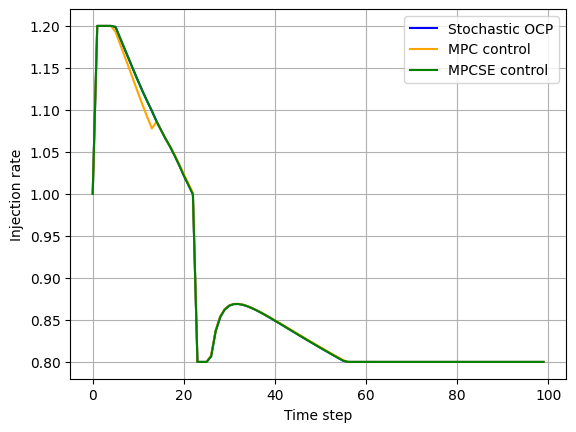

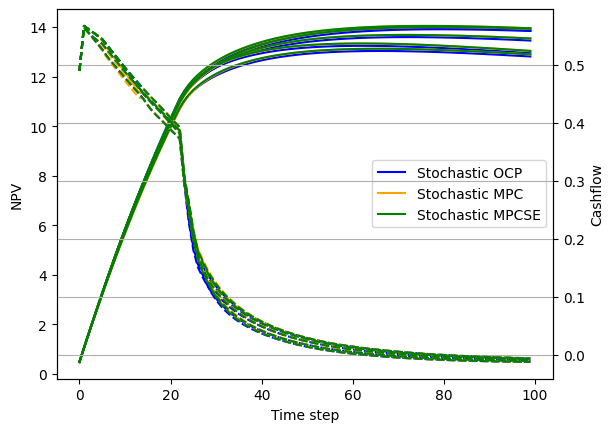

In [27]:
fig, ax = plt.subplots()
qocp = np.load("./data/socp_qocp.npy")
qmpc = np.load("./data/smpc_qmpc.npy")
qmpc_wse = np.load("./data/smpc_wse_qmpc.npy")
ax.plot(qocp, label="Stochastic OCP", color="blue")
ax.plot(qmpc[:-1], label="MPC control", color="orange")
ax.plot(qmpc_wse[:-1], label="MPCSE control", color="green")
ax.legend()
ax.set_ylabel("Injection rate")
ax.set_xlabel("Time step")
ax.set_ylim([0.78, 1.22])
ax.grid()
plt.show()

socp_cost = np.load("./data/socp_cost_traj.npy")[:,:,0,0]
smpc_cost = np.load("./data/smpc_cost_traj.npy")[:,:,0,0]
smpc_cost_wse = np.load("./data/smpc_wse_cost_traj.npy")[:,:]

fig, ax = plt.subplots()
ax.plot(np.cumsum(socp_cost, axis=0), color='blue')
ax.plot(np.cumsum(smpc_cost, axis=0), color='orange')
ax.plot(np.cumsum(smpc_cost_wse, axis=0), color='green')
ax.plot([], color='blue', label="Stochastic OCP")
ax.plot([], color='orange', label="Stochastic MPC")
ax.plot([], color='green', label="Stochastic MPCSE")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(socp_cost, color="blue", linestyle="dashed")
ax1.plot(smpc_cost, color="orange", linestyle="dashed")
ax1.plot(smpc_cost_wse, color="green", linestyle="dashed")
ax1.set_ylabel("Cashflow")

ax1.grid()



In [28]:
npv_socp = np.cumsum(socp_cost, axis=0)[-1,:].mean()
npv_smpc = np.cumsum(smpc_cost, axis=0)[-1,:].mean()
npv_smpc_wse = np.cumsum(smpc_cost_wse, axis=0)[-1,:].mean()
npv_socp, npv_smpc, npv_smpc_wse

(13.379658299576372, 13.466571841659094, 13.46807098322554)

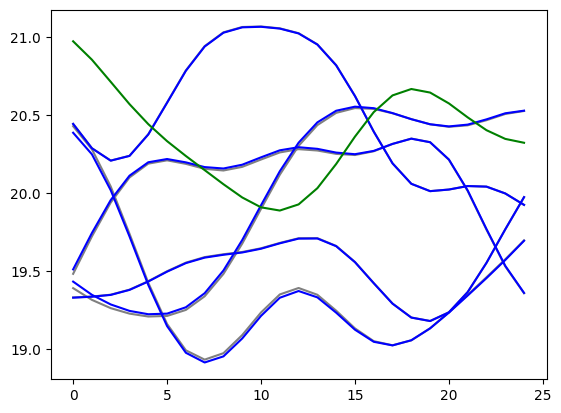

In [29]:
plt.plot(aw_traj[0],color="grey")
plt.plot(aw_traj[-1],color="blue")
plt.plot(a_true,color="green")

In [26]:
for i in range(n_mpc_steps):
    if Sw_traj[i][-1] > 0.5:
        print(i)

32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


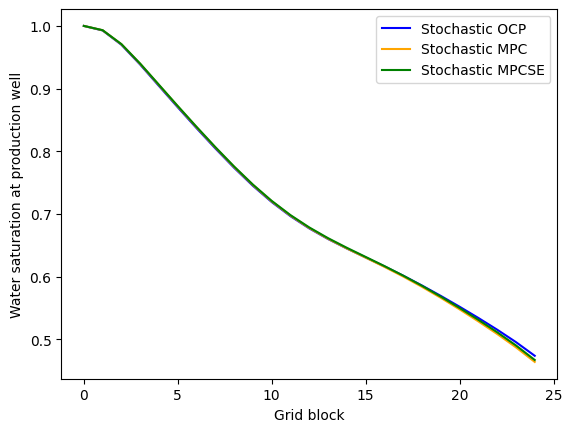

In [33]:
Sw_socp = np.load("./data/socp_Sw_traj.npy")
Sw_smpc = np.load("./data/smpc_Sw_traj.npy")
Sw_smpc_wse = np.load("./data/smpc_wse_Sw_traj.npy")

# get the last saturation profile at production well for all ensemble members
f1 = Sw_socp[-1, [(nx-1)+i*nx for i in range(Ne)], 0]
f2 = Sw_smpc[-1, [(nx-1)+i*nx for i in range(Ne)], 0]
f3 = Sw_smpc_wse[-1, [(nx-1)+i*nx for i in range(Ne)]]

# compare the saturation profiles at breakthrough time
t_breakthrough = 29
plt.plot(Sw_socp[t_breakthrough,-25:], color="blue")
plt.plot(Sw_smpc[t_breakthrough,-25:], color="orange")
plt.plot(Sw_smpc_wse[t_breakthrough,-25:], color="green")
plt.plot([], color="blue", label="Stochastic OCP")
plt.plot([], color="orange", label="Stochastic MPC")
plt.plot([], color="green", label="Stochastic MPCSE")
plt.xlabel("Grid block")
plt.ylabel("Water saturation at production well")
plt.legend()

In [36]:
f1 - f3

array([-0.00103323, -0.00118826, -0.00063995, -0.0010218 , -0.00119999])